<a href="https://colab.research.google.com/github/FemiAdesola/Data-Science/blob/main/Maintenance_%26_Manufacturing_Department.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <ins>**THE DATA SCIENCE FOR BUSINESS**


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=1rcxnQuLqFyn8l9hQmdyp-yxSaXhxJPed"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Predict Defects Using Deep Learning
  </td></tr>
</table>


# <ins>**Maintenance & Manufacturing Department**
+ Artificial Intelligence and Machine Learning are transforming the manufacturing industry. According to the report released by World Economic Forum, these technologies will play significant roles in the fourth industrial revolution. Major areas which can be benefited from this are:
  + Maintenance Department
  + Production Department
  + Supply Chain Department
+ Deep learning has been proven to be superior in detecting and localizing defects using imagery data which could significantly improve the production efficiency in the manufacturing industry.
+ Great Example from LandingAI:

https://landing.ai/defect-detection


## <ins>**Case Study**

In this case study, we will assume that you work as an Al/ ML consultant.
+ You have been hired by a steel manufacturing company in San Diego and you have been tasked to automate the process of detecting and localizing defects found in Steel manufacturing.
+ Detecting defects would help in improving the quality of manufacturing as well as in reducing the waste due to production defects.
+ The team has collected images of steel surfaces and have approached you to develop a model that could detect and localize defects in real-time.
+ You have been provided with 12600 images that contain 4 types of defects, along with their location in the steel surface.

![alt text](https://drive.google.com/uc?id=1nzRA5KU0eWo0YPZtSxUWOoMlvooKGCkt)

## <ins>**WHAT IS IMAGE SEGMENTATION?**
+ The goal of image segmentation is to understand and extract information from images at the pixel-level.
+ Image Segmentation can be used for object recognition and localization which offers tremendous value in many applications such as medical imaging and self-driving cars etc.
+ The goal of image segmentation is to train a neural network to produce pixel-wise mask of the image.
+ Modern image segmentation techniques are based on deep learning approach which makes use of common architectures such as CNN, FCs (Fully Convolution Networks) and Deep Encoders-Decoders.
+ You will be using ResUNet architecture to solve the current task.
+ When we applied CNN for image classification problems? We had to convert the image into a vector and possibly add a classification head at the end.
+ However, in case of Unet, we convert (encode) the image into a vector followed by up sampling (decode) it back again into an image.
+ In case of Unet, the input and output have the same size so the size of the image is preserved.
+ **For classical CNNs**: they are generally used when the entire image is needed to be classified as a class label.
+ **For Unet**: pixel level classification is performed.
+ **U-net** formulates a loss function for every pixel in the input image.
+ **Softmax** function is applied to every pixel which makes the segmentation problem works as a classification problem where classification is performed on every pixel of the image

https://aditi-mittal.medium.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f


# <ins>**IMPORT LIBRARIES AND DATASETS**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from google.colab import files
%matplotlib inline


In [5]:
# You will need to mount your drive using the following commands:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <ins>**MASK:**
+ The goal of image segmentation is to understand the image at the pixel level. It associates each pixel with a certain class. The output produce by image segmentation model is called a
"mask" of the image.
+ Masks can be represented by associating pixel values with their coordinates. For example if we have a black image of shape (2,2), this can be represented as:\
[[0, 0], B B\
[0, 0]] B B

If our output mask is as follows:\
[[255, 01, W B \
[0,255, B W]]

+ To represent this mask we have to first flatten the image into a
1-D array. This would result in something like [255,0,0,255] for mask. Then, we can use the index to create the mask. \
Finally we would have something like [1,0,0,1] as our mask.

## <ins>**RUN LENGTH ENCODING (RLE):**
+ Sometimes it is hard to represent mask using index as it would make the length of mask equal to product of height and width of the image
+ To overcome this we use lossless data compression technique called Run-length encoding (RLE), which stores sequences that contain many consecutive data elements as a single data value followed by the count.
+ For example, assume we have an image (single row) containing plain black text on a solid white background. **B** represents black pixel and **W** represents white: \

  WWWWWWWWWWWWBWWWWWWWW \
  WWWWWBBBWWWWWWWWWWWWW \
  WWWWWWWWWWWWBWWWWWWWW \
  WWWWWW

+ Run-length encoding (RLE):
    + 12W1B12W3B24W1B14W

+ This can be interpreted as a sequence of twelve Ws, one B, twelve Ws, three Bs, etc.,

In [6]:
# data containing defect images with segmentation mask
defect_class_mask_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Manufacturing/train_M.csv')

And the goal of image segmentation is to train in vour network to produce pixel y's mask of the image.

In [7]:
# data containing defective and non defective images
all_images_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Manufacturing/defect_and_no_defect.csv')

In [8]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [9]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


# <ins>**VISUALIZE AND EXPLORE DATASET**

In [10]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [11]:
defect_class_mask_df.head(10)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


For determing how many images that belongs to each of these classes.

Text(0.5, 1.0, 'Number of images per class')

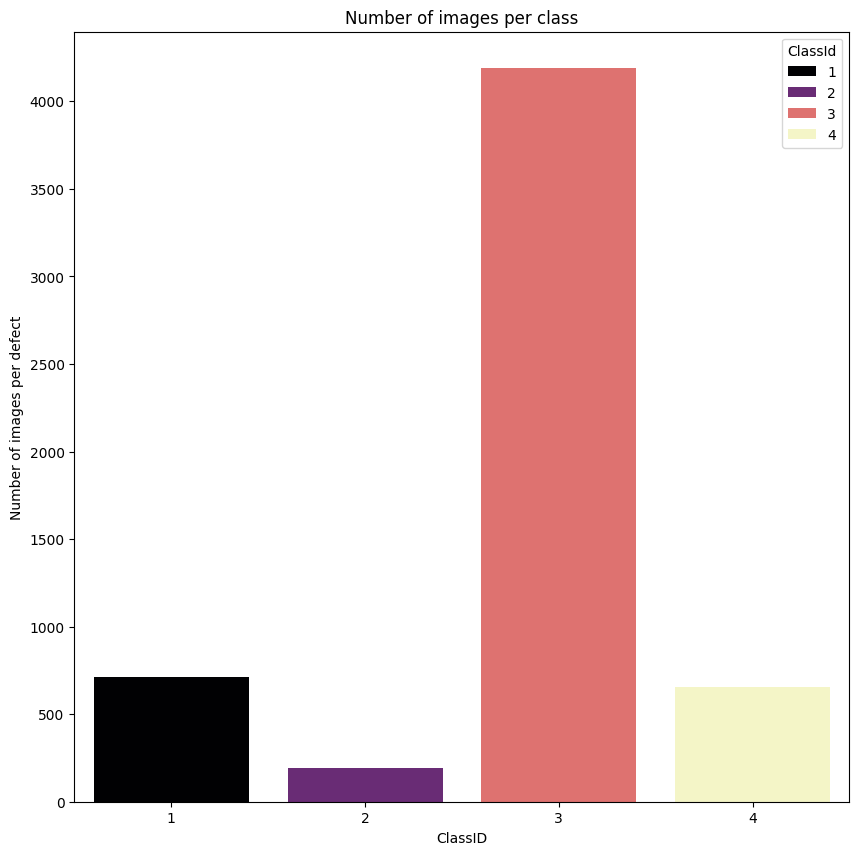

In [12]:
plt.figure(figsize=(10,10))
#sns.countplot(defect_class_mask_df['ClassId'])
sns.countplot(x = 'ClassId', hue='ClassId', data = defect_class_mask_df, palette= "magma")
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [13]:
# Some images are classified with more than one defect, let's explore this futher
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()


In [14]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [15]:
defect_type.value_counts()

mask
1    5201
2     272
3       1
Name: count, dtype: int64

+ we have one image with 3 types of defects
+ we have 272 images with 2 types of defects
+ we have 5201 images with 1 type of defect

In [16]:
defect_type.info()

<class 'pandas.core.series.Series'>
Index: 5474 entries, 0002cc93b.jpg to ffffd67df.jpg
Series name: mask
Non-Null Count  Dtype
--------------  -----
5474 non-null   int64
dtypes: int64(1)
memory usage: 214.6+ KB


### **For plotting defect count**

Text(0.5, 1.0, 'Number of defects in image')

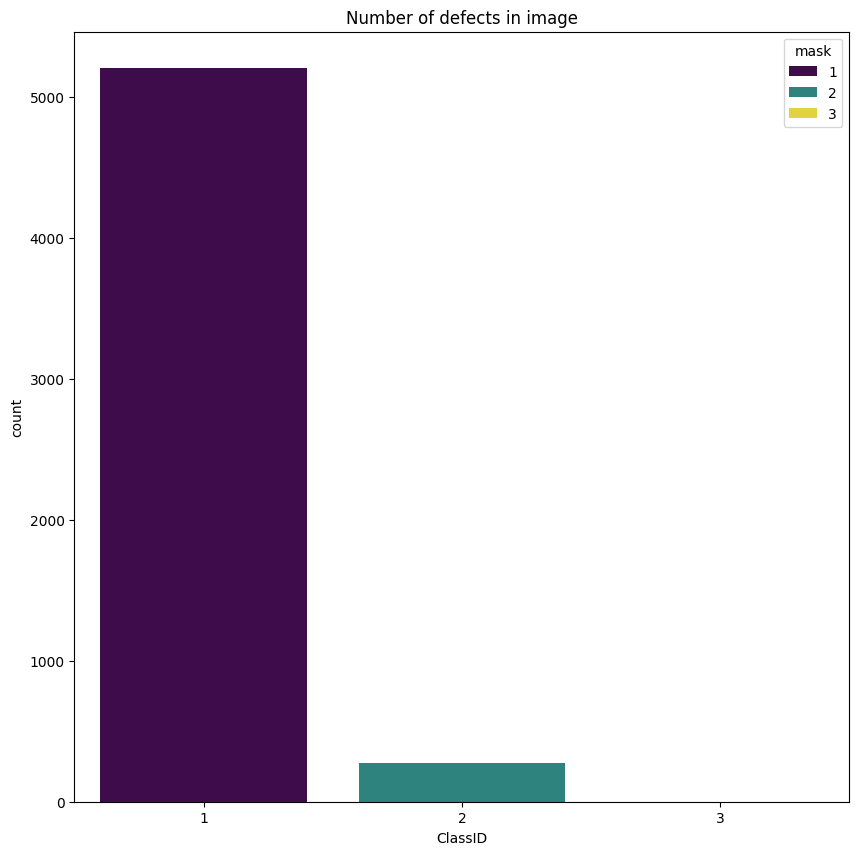

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, hue = defect_type.value_counts().index, y = defect_type.value_counts(), palette= "viridis" )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [18]:
defect_class_mask_df.shape

(5748, 4)

In [19]:
all_images_df.shape

(12997, 2)

### For counting defective and non defective images


In [20]:
# for counting defective and non defective images

all_images_df.label.value_counts()

label
1    7095
0    5902
Name: count, dtype: int64

### For plotting defective and non defective images

Text(0.5, 1.0, 'Defect and non-defect images')

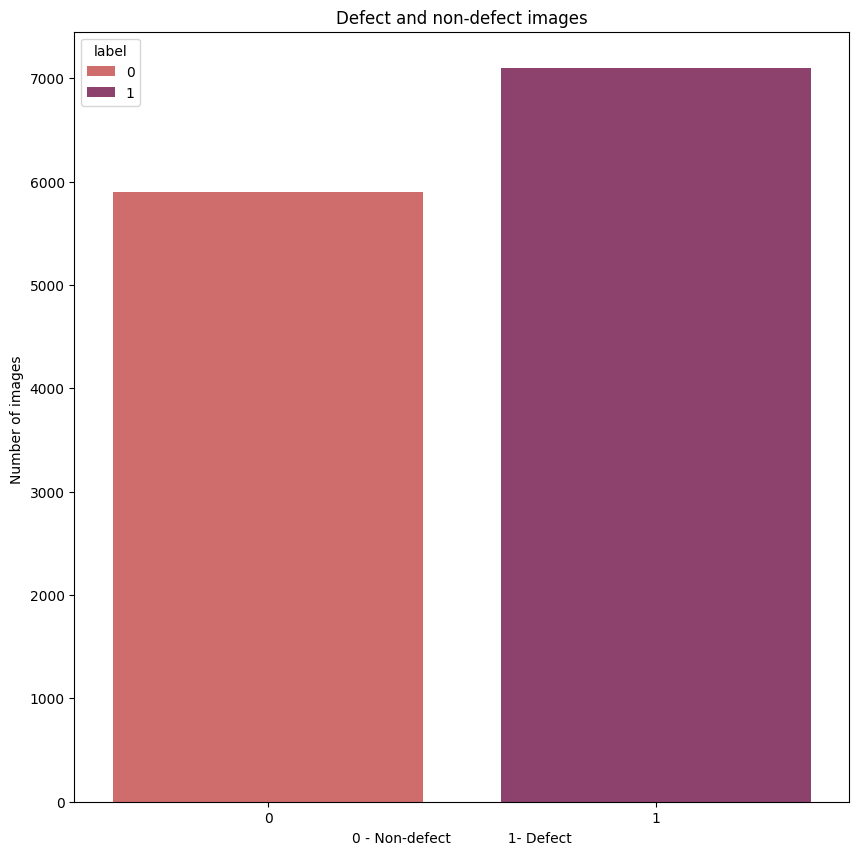

In [21]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, hue = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts(), palette= "flare")
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

**For Importing google colab patches with cv2_inshow**

In [22]:
from google.colab.patches import cv2_imshow

In [23]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600

train_dir = '/content/drive/My Drive/Colab Notebooks/Manufacturing/train_images/'

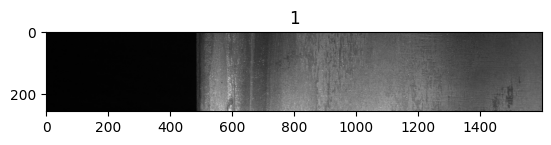

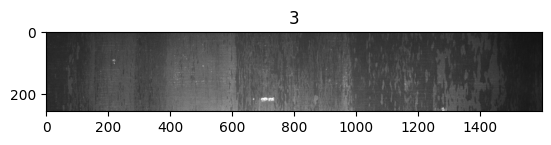

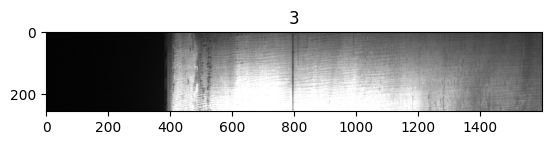

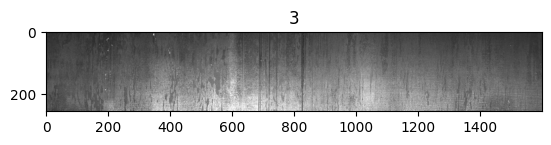

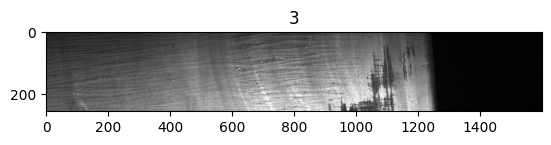

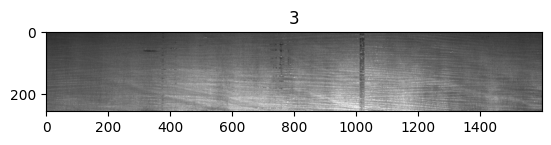

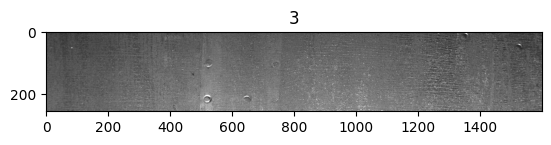

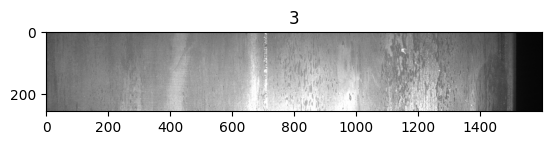

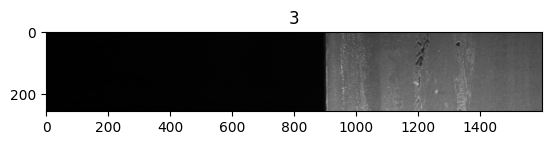

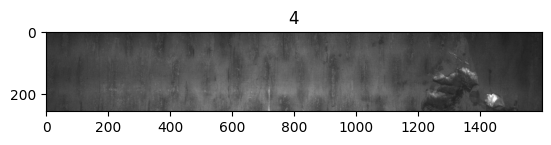

In [24]:
for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)




These are functions that do the conversions for us
+ rle2mask ,
+ ask2rle


In [25]:
# since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask.
# we can convert the mask back again to RLE to assess model performance (accuracy).
# Code source for these function came from: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

%cd /content/drive/My Drive/Colab Notebooks/Manufacturing
from utilities import rle2mask , mask2rle


/content/drive/My Drive/Colab Notebooks/Manufacturing


In [26]:
train_dir = '/content/drive/My Drive/Colab Notebooks/Manufacturing/train_images/'

In [27]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [28]:
# Let's try to use the rle2mask on a sample image
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape


(256, 1600)

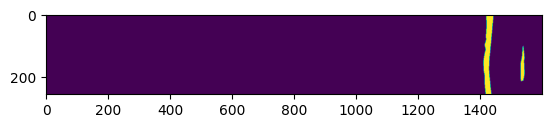

In [29]:
# Let's show the mask
plt.imshow(mask)


(256, 1600, 3)

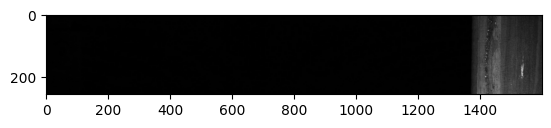

In [ ]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

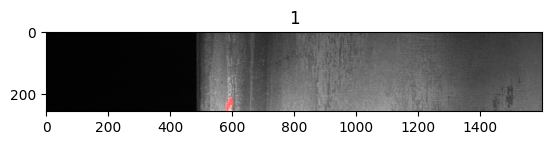

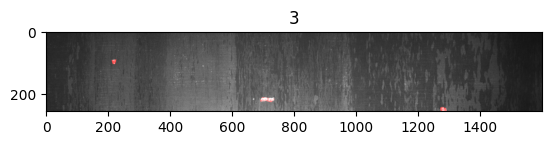

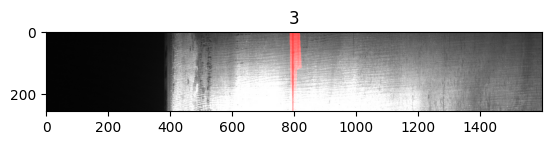

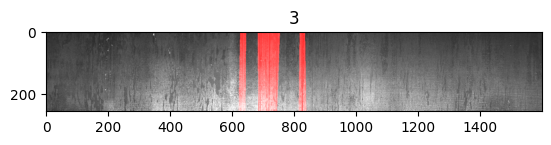

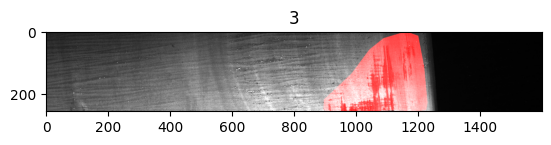

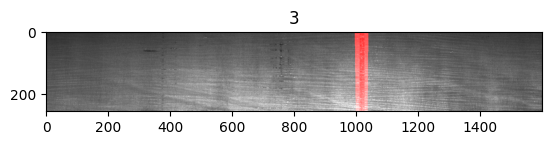

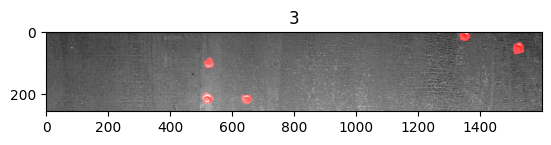

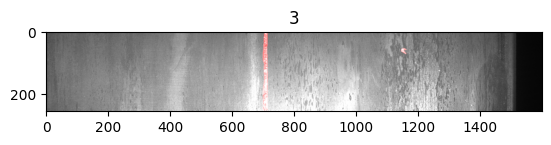

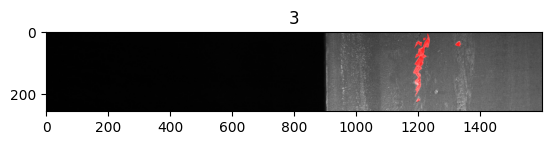

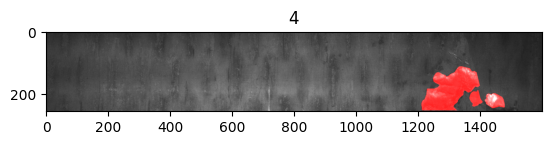

In [30]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])

  # Let's color the pixels with values = 1
  img[mask == 1,0] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])


# <ins>**UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS, RESNETS, AND TRANSFER LEARNING**

![alt text](https://drive.google.com/uc?id=1HD2FFDD8fonGMyHARfw8ZqaofP3Udek6)

![alt text](https://drive.google.com/uc?id=1-HAo3xcPKGoH-gG8495p12o33nUC1j6W)

![alt text](https://drive.google.com/uc?id=1zmzg777lS1PGkTyJXA5fPmrJ9mcKneDi)


## <ins>**TRANSFER LEARNING TRAINING STRATEGIES**
+ **Strategy #1 Steps:**
  + Freeze the trained CNN network weights from the first layers.
  + Only train the newly added dense layers (with randomly initialized weights).
+ **Strategy #2 Steps:**
  + Initialize the CNN network with the pre-trained weights
  + Retrain the entire CNN network while setting the learning rate to be very small, this is critical to ensure that you do not aggressively change the trained weights.
+ **Transfer learning advantages are:**
  + Provides fast training progress, you don't have to start from scratch using randomly initialized weights
  + You can use small training dataset to achieve incredible results

# <ins>**BUILD AND TRAIN A DEEP LEARNING MODEL TO DETECT WHETHER A DEFECT IS PRESENT IN AN IMAGE OR NOT**

In [31]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [32]:
# split the data (defective and non defective) into training and testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [33]:
train.shape

(11047, 2)

In [34]:
test.shape

(1950, 2)

In [35]:
train_dir = '/content/drive/My Drive/Colab Notebooks/Manufacturing/train_images/'

### For creating a **mage generator** for the **training and validation dataset**
+ we will divide the data to training, validation and testing


### For importing ImageDataGenerator from keras_preprocessing.image import

### For creating a data generator which scales the data from 0 to 1 and makes validation split of 0.15

In [36]:
# Training = 9390
# validation = 1657
# testing = 1950

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [37]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))


Found 1950 validated image filenames.


In [38]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [39]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [40]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [41]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)


In [42]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [43]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [44]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [45]:
tf.config.set_visible_devices([], "GPU")

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
# Get the GPU memory fraction to allocate
gpu_memory_fraction = 0.5

# Create GPUOptions with the fraction of GPU memory to allocate
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

# Create a session with the GPUOptions
session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
# (WARNING TAKES LONG TIME (~90 mins)!)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

<ipython-input-47-48255e3d6683>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])


Epoch 1/20
586/586 [==============================] - ETA: 0s - loss: 0.5729 - accuracy: 0.7305 
Epoch 1: val_loss improved from inf to 1.07726, saving model to resnet-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


586/586 [==============================] - 9782s 17s/step - loss: 0.5729 - accuracy: 0.7305 - val_loss: 1.0773 - val_accuracy: 0.5334
Epoch 2/20
536/586 [==========================>...] - ETA: 13:11 - loss: 0.4372 - accuracy: 0.7943

In [46]:
# save the trained model architecture for future use
model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

# <ins>**ASSESS TRAINED MODEL PERFORMANCE**

In [47]:
with open('/content/drive/My Drive/Colab Notebooks/Manufacturing/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

In [48]:
# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/Colab Notebooks/Manufacturing/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [49]:
# Make prediction (WARNING TAKES LONG TIME (~10 mins)!)
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


121/121 [==============================] - 747s 6s/step


In [50]:
test_predict

array([[1.9659985e-05],
       [4.6049653e-09],
       [9.9999148e-01],
       ...,
       [1.4026747e-03],
       [6.3826488e-03],
       [9.9071681e-01]], dtype=float32)

In [51]:
# Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
# The network is initially used to classify whether the image has defect or not
# Then these images (defective) is passed through the segmentation network to get the localization and type of defect.
# Let's choose 0.01, to make sure, that we omit images from passing through the segmentation network only we are highly certain that it has no defect and if we are not confident, we can pass this image through the segmentation
# network

predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)


In [52]:
len(predict)

1936

In [53]:
# since we have used test generator, it limited the images to 1936, due to batch size
original = np.asarray(test.label)[:1936]
len(original)


1936

In [54]:
# For importing accuracy_score from sklearn.metrics

from sklearn.metrics import accuracy_score

In [55]:
# Find the accuracy of the model
accuracy = accuracy_score(original, predict)
accuracy

0.8925619834710744

<Axes: >

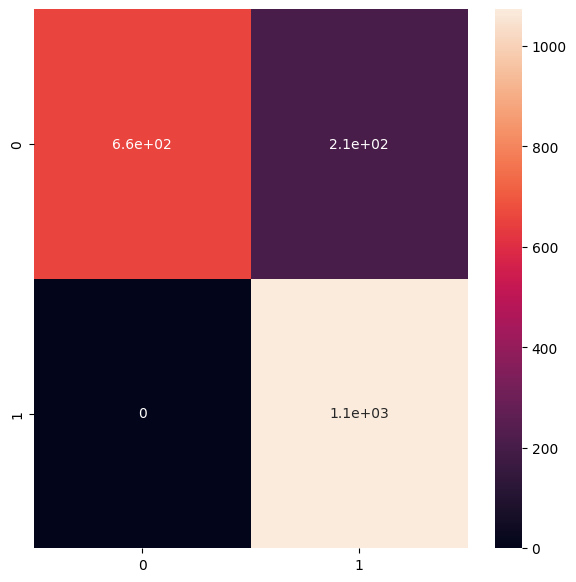

In [56]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)


### **For Printing the classification**

In [57]:
# Print the classification

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       863
           1       0.84      1.00      0.91      1073

    accuracy                           0.89      1936
   macro avg       0.92      0.88      0.89      1936
weighted avg       0.91      0.89      0.89      1936



# <ins>**UNDERSTAND THE THEORY AND INTUITION BEHIND RESUNET (SEGMENTATION)**

![alt text](https://drive.google.com/uc?id=1D7mAjdEFv6cIb4UFiXwndJy6enzZQzpb)

![alt text](https://drive.google.com/uc?id=1TK1Y9gry62NORdA-EjWD8HJadBZMa_sL)

## <ins>**RESUNET ARCHITECTURE:**
1. Encoder or contracting path consist of 4 blocks:
  + First block consists of 3×3 convolution layer + Relu + Batch-Normalization
  + Remaining three blocks consist of Res-blocks followed by
Max-pooling 2x2.
2. Bottleneck:
  + It is in-between the contracting and expanding path.
  + It consist of Res-block followed by up sampling conv layer
2x2.
3. Expanding or Decoder path consist of 4 blocks:
  + 3 blocks following bottleneck consist of Res-blocks followed by up-sampling conv layer 2 x 2
  + Final block consist of Res-block followed by 1x1 conv layer.


## **RESUNET ADDITIONAL RESOURCES:**

Paper #1: https://arxiv.org/abs/1505.04597


Paper #2: https://arxiv.org/abs/1904.00592



https://aditi-mittal.medium.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f


# <ins>**BUILD A RESUNET SEGMENTATION MODEL**

## For importing train_test_split from sklearn.model_selection

In [121]:
from sklearn.model_selection import train_test_split

In [142]:
#spliting the data into train and test data
X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)


In [143]:
# For creating separate list for imageId, classId and rle to pass into the generator
train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [144]:
from utilities import DataGenerator

### For creating image generators

In [145]:
# For creating image generators

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)

In [146]:
def resblock(X, f):


  # making a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [147]:
# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [148]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


## Loss function:

We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [161]:
%cd /content/drive/My Drive/Colab Notebooks/Manufacturing

/content/drive/My Drive/Colab Notebooks/Manufacturing


In [162]:
from utilities import focal_tversky, tversky_loss, tversky

In [163]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [164]:
# By using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


In [165]:
# For saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [166]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

<ipython-input-166-0fb4d5307fb1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])


Epoch 1/40


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/content/drive/My Drive/Colab Notebooks/Manufacturing/utilities.py", line 313, in focal_tversky  *
        pt_1 = tversky(y_true, y_pred)
    File "/content/drive/My Drive/Colab Notebooks/Manufacturing/utilities.py", line 303, in tversky  *
        true_pos = K.sum(y_true_pos * y_pred_pos)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.


In [167]:
# For saving the model for future use
model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)


# <ins>**ASSESS TRAINED SEGMENTATION MODEL PERFORMANCE**

In [169]:
from utilities import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [170]:
# data containing test images for segmentation task

test_df = pd.read_csv('test.csv')

In [171]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [172]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

In [173]:
from utilities import prediction

# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

1/1 [==============================] - 0s 163ms/step


In [174]:
# For creating a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


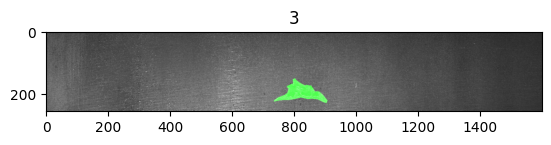

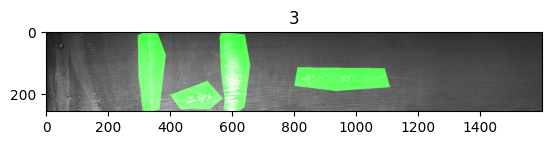

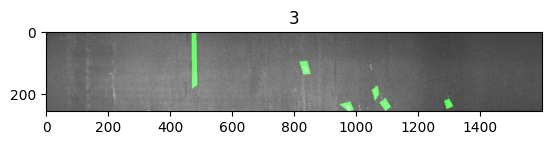

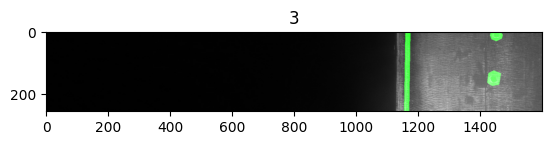

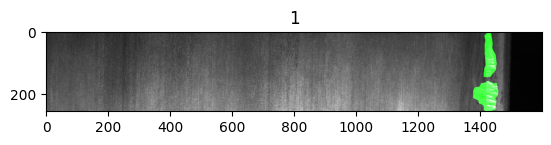

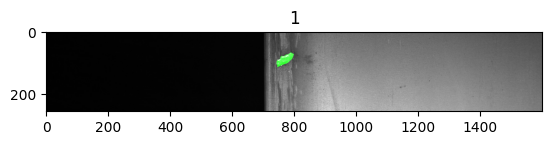

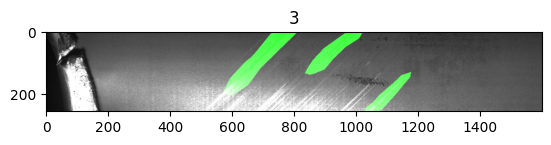

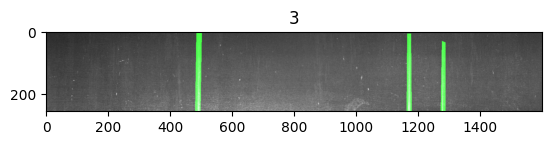

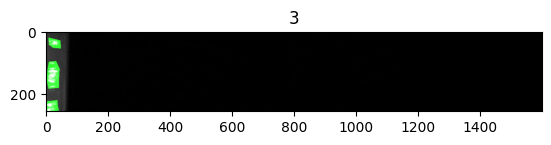

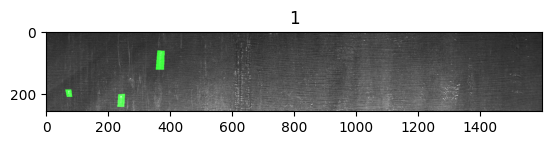

In [178]:
# Let's show the images along with their original (ground truth) masks
for i in range(10):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)


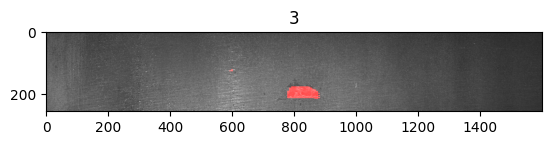

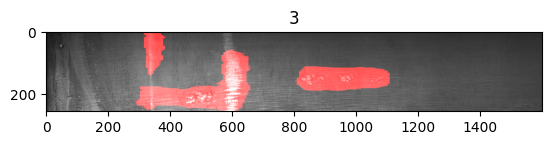

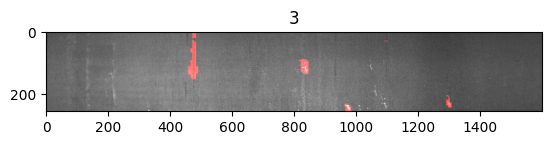

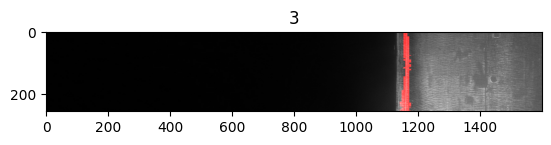

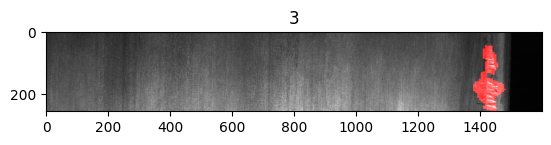

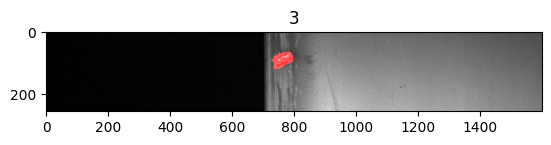

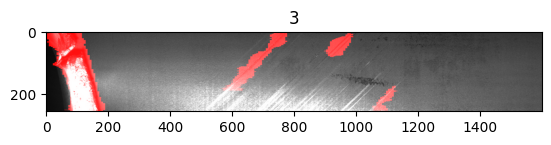

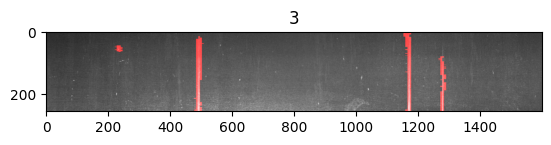

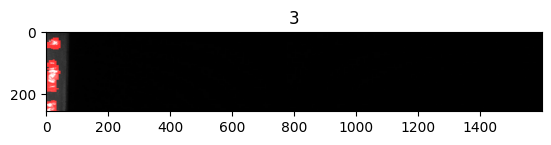

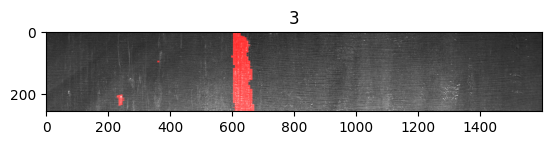

In [179]:
# visualize the results (model predictions)

directory = "train_images"

for i in range(10):

  # read the images using opencv and convert to rgb format
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # get the mask for the image from rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)